In [118]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Machine Learning packages
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Load data
df = pd.read_csv('breast-cancer.csv')
pd.set_option('display.max_colwidth', None)
df

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events
...,...,...,...,...,...,...,...,...,...,...
281,50-59,ge40,30-34,6-8,yes,2,left,left_low,no,no-recurrence-events
282,50-59,premeno,25-29,3-5,yes,2,left,left_low,yes,no-recurrence-events
283,30-39,premeno,30-34,6-8,yes,2,right,right_up,no,no-recurrence-events
284,50-59,premeno,15-19,0-2,no,2,right,left_low,no,no-recurrence-events


In [3]:
df.describe()

,deg-malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [5]:
df.isnull().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
Class          0
dtype: int64

In [6]:
df.Class.value_counts()

Class
no-recurrence-events    201
recurrence-events        85
Name: count, dtype: int64

## Analysis

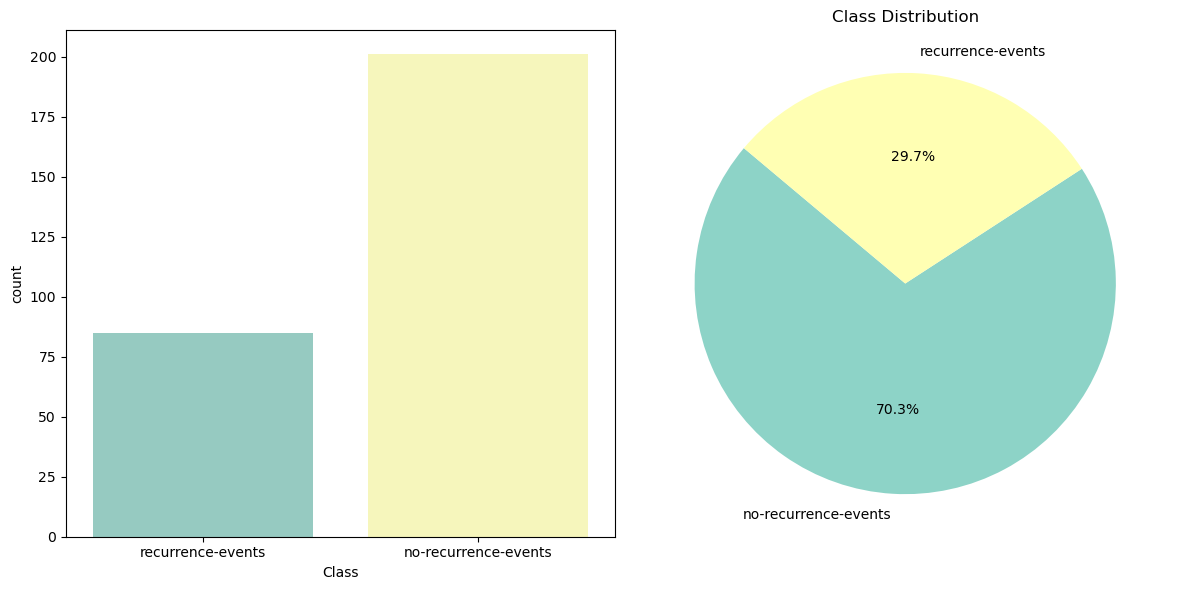

In [7]:
# check data balance
sns.set_palette("Set3")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df, x='Class', ax=ax1)
ax2.pie(df['Class'].value_counts(), labels=df['Class'].value_counts().index, autopct='%1.1f%%', startangle=140)
ax2.set_title('Class Distribution')
ax2.axis('equal')
plt.tight_layout()
plt.show()

**~30%** Recurrence and **~70%** Non-Recurrence. Imbalanced data

In [8]:
df.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

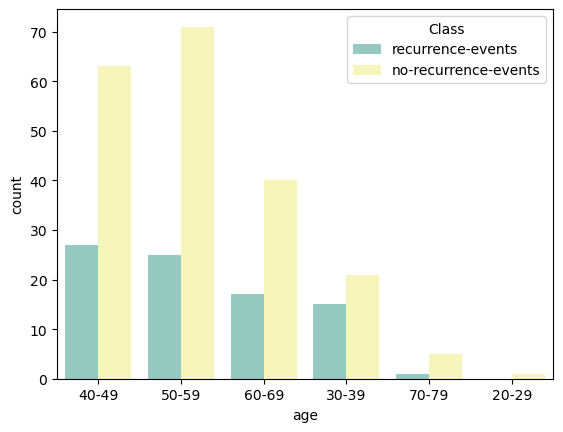

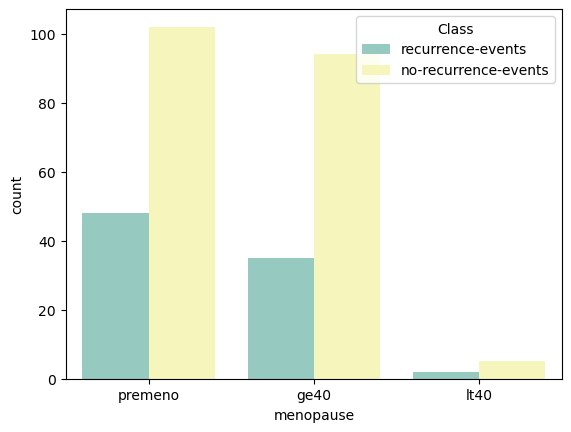

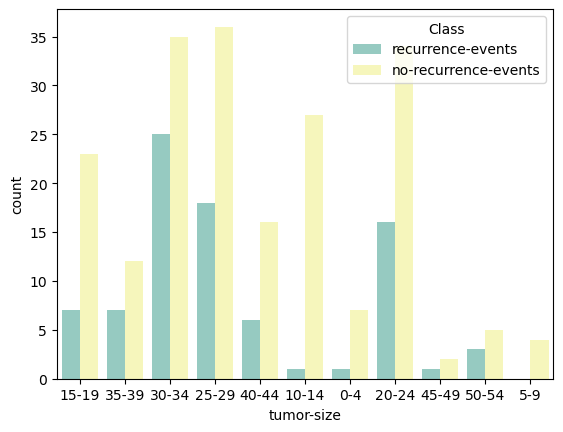

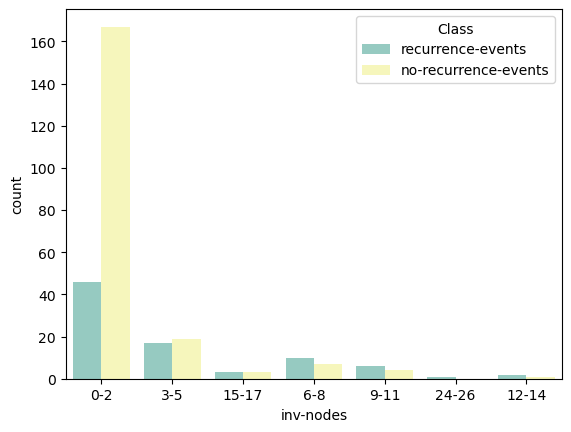

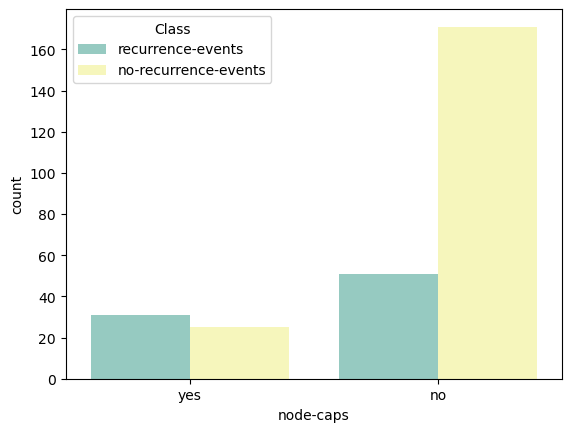

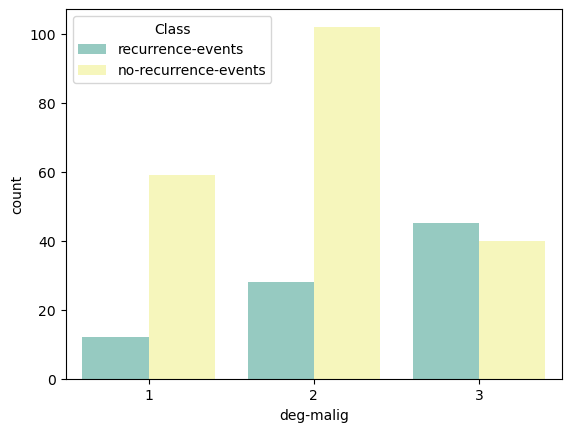

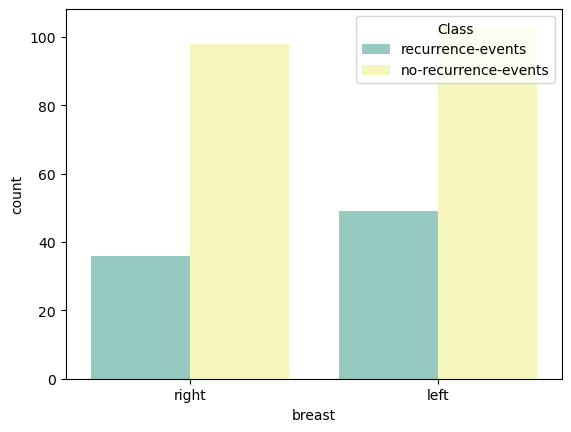

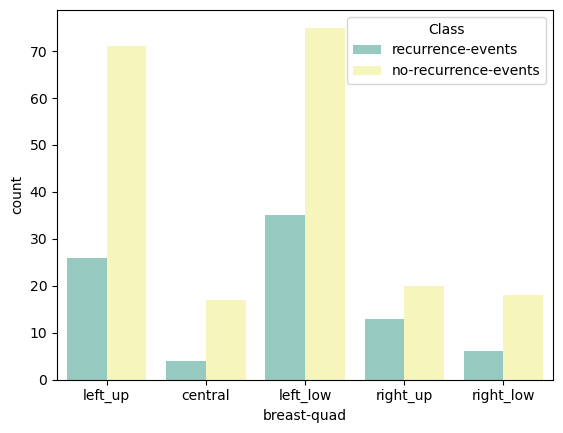

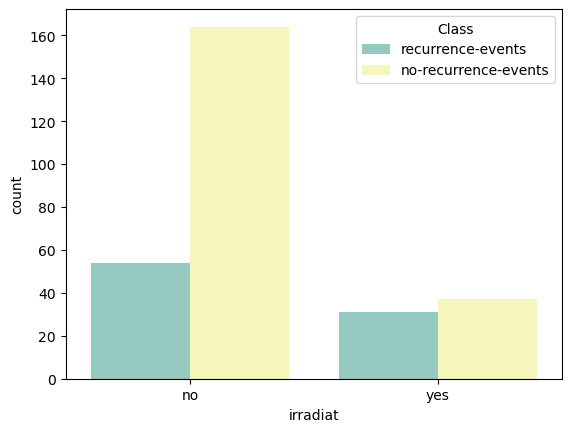

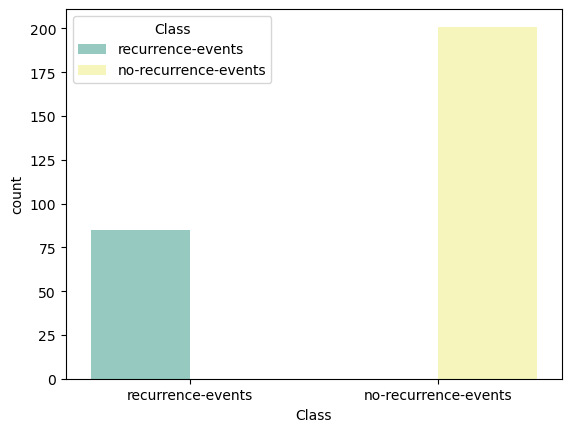

In [9]:
for i in df.columns:
    sns.countplot(data=df, x=i, hue='Class')
    plt.show()

Conclusion:
- All the features seem relecvant so no feature to drop.
- Data is heavily imbalanced in target variables
- Breast-quad also has imbalance with more entries for Left, but give the lack of data collection context and subject expertise no changes will be done. 

## Data processing

In [10]:
#Create a copy of dataframe
df_copy=df.copy()

In [11]:
df_copy.isnull().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
Class          0
dtype: int64

In [12]:
df['breast-quad'].value_counts()

breast-quad
left_low     110
left_up       97
right_up      33
right_low     24
central       21
Name: count, dtype: int64

In [13]:
#dropping the row because it's just 1 row
df_copy.dropna(subset=['breast-quad'], inplace=True)

In [14]:
df['node-caps'].value_counts()

node-caps
no     222
yes     56
Name: count, dtype: int64

In [15]:
# replacing with the majority value
df_copy.loc[df_copy['node-caps'].isnull(), 'node-caps'] = 'no'

In [16]:
df_copy.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

**Encoding Variables**

First label encoding for variables that have numerical significance [age, tumor size, node size]

In [17]:
df_copy.age.unique()

array(['40-49', '50-59', '60-69', '30-39', '70-79', '20-29'], dtype=object)

In [18]:
# mapping from unique values to integer values
age_mapping = {
    '20-29': 1,
    '30-39': 2,
    '40-49': 3,
    '50-59': 4,
    '60-69': 5,
    '70-79': 6
}
# Replace the values in the 'age' column with the integer values
df_copy['age'] = df_copy['age'].replace(age_mapping)

In [19]:
df_copy['tumor-size'].unique()

array(['15-19', '35-39', '30-34', '25-29', '40-44', '10-14', '0-4',
       '20-24', '45-49', '50-54', '5-9'], dtype=object)

In [20]:
# mapping from unique values to integer values
tumor_mapping = {
    '0-4': 1,
    '5-9': 2,
    '10-14': 3,
    '15-19': 4,
    '20-24': 5,
    '25-29': 6,
    '30-34': 7,
    '35-39': 8,
    '40-44': 9,
    '45-49': 10,
    '50-54': 11
}
# Replace the values in the 'age' column with the integer values
df_copy['tumor-size'] = df_copy['tumor-size'].replace(tumor_mapping)

In [21]:
df['inv-nodes'].unique()

array(['0-2', '3-5', '15-17', '6-8', '9-11', '24-26', '12-14'],
      dtype=object)

In [22]:
inv_mapping = {
    '0-2': 1,
    '3-5': 2,
    '6-8': 3,
    '9-11': 4,
    '12-14': 5,
    '15-17': 6,
    '24-26': 7
}
df_copy['inv-nodes'] = df_copy['inv-nodes'].replace(inv_mapping)

In [23]:
df_copy.Class.unique()

array(['recurrence-events', 'no-recurrence-events'], dtype=object)

One hot encoding the target and other categorical variables

In [24]:
class_map={'recurrence-events': 1, 'no-recurrence-events': 0}
df_copy['Class']=df_copy['Class'].replace(class_map)

In [25]:
# Split Target and Variables
X=df_copy.drop('Class',axis=1)
y=df_copy['Class']

In [26]:
# encoding all categorical variables with dummmy trap
dummy_X=pd.get_dummies(X,drop_first=True)

In [27]:
dummy_X

,age,tumor-size,inv-nodes,deg-malig,menopause_lt40,menopause_premeno,node-caps_yes,breast_right,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_yes
0,3,4,1,3,False,True,True,True,False,True,False,False,False
1,4,4,1,1,False,False,False,True,False,False,False,False,False
2,4,8,1,2,False,False,False,False,True,False,False,False,False
3,3,8,1,3,False,True,True,True,True,False,False,False,True
4,3,7,2,2,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,4,7,3,2,False,False,True,False,True,False,False,False,False
282,4,6,2,2,False,True,True,False,True,False,False,False,True
283,2,7,3,2,False,True,True,True,False,False,False,True,False
284,4,4,1,2,False,True,False,True,True,False,False,False,False


Address class imbalance using SMOTE to synthetically resample the data

In [28]:
# Create a SMOTE object to address class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
# Fit and resample the data
X_resampled, y_resampled = smote.fit_resample(dummy_X, y)

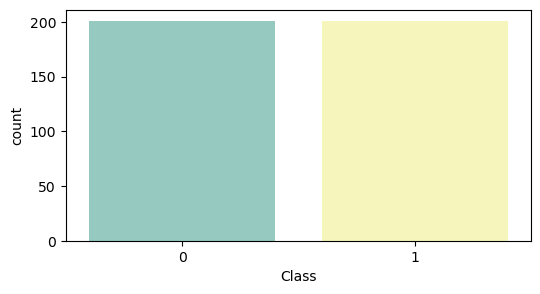

In [43]:
# check data balance
plt.figure(figsize=(6,3))
sns.countplot(x=y_resampled)
plt.show()

The data is balanced for the target

In [110]:
combined_data = pd.concat([X_resampled, y_resampled], axis=1)

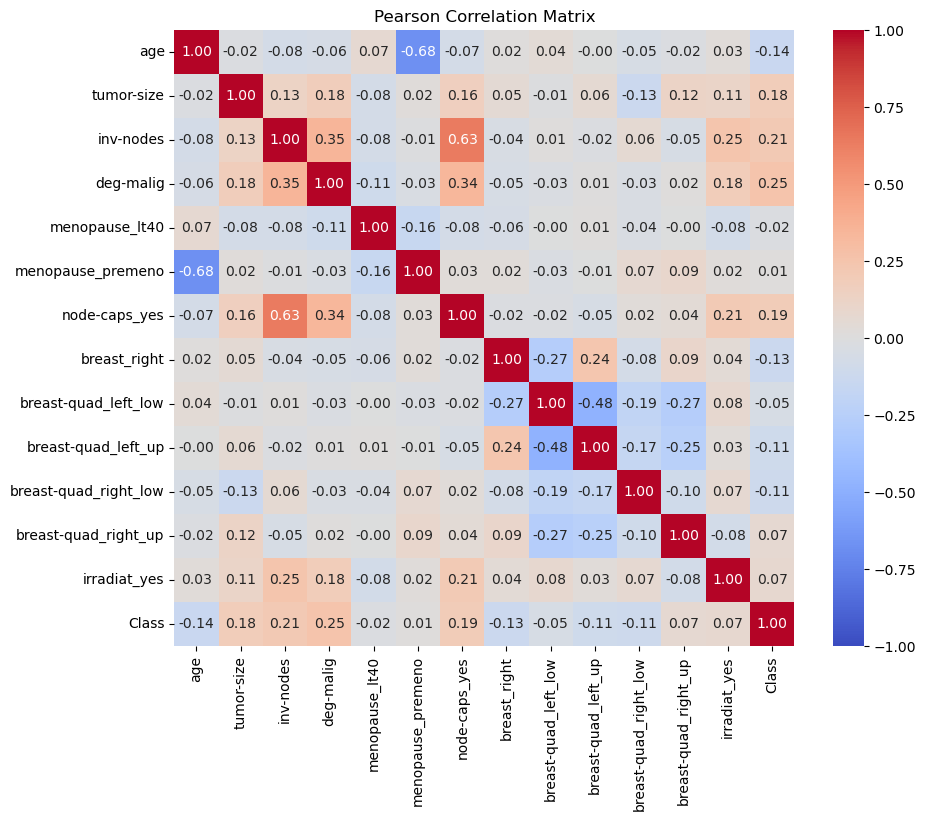

In [112]:
plt.figure(figsize=(10, 8))
sns.heatmap(combined_data.corr(method='pearson'), annot=True, cmap="coolwarm", fmt=".2f",vmin=-1, vmax=1)
plt.title("Pearson Correlation Matrix")
plt.show()

- Degree of malignance is the most correlated factor to reccurence
- inv-nodes & tumor size also show significant positive correlation.
- A negative node cap lowers the risk of breast cancer reccurence

In [129]:
# Split Data
X_train, X_test, Y_train, Y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=2)

In [130]:
def plot_confusion_matrix(y, y_predict):
    "This function plots the confusion matrix"
    
    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer format
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not Churn', 'Churn'])
    ax.yaxis.set_ticklabels(['Not Churn', 'Churn'])
    plt.show()

## Model Building

Logistic Reg

In [46]:
parameters_lr={
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'], 
    'solver': ['lbfgs']
}

In [47]:
%%time
lr=LogisticRegression()
grid_search_lr = GridSearchCV(
    estimator = lr,
    param_grid = parameters_lr,
    scoring = 'accuracy',
    cv = 5
)
logreg_cv=grid_search_lr.fit(X_train,Y_train)

CPU times: total: 500 ms
Wall time: 479 ms


In [48]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.6792788461538461


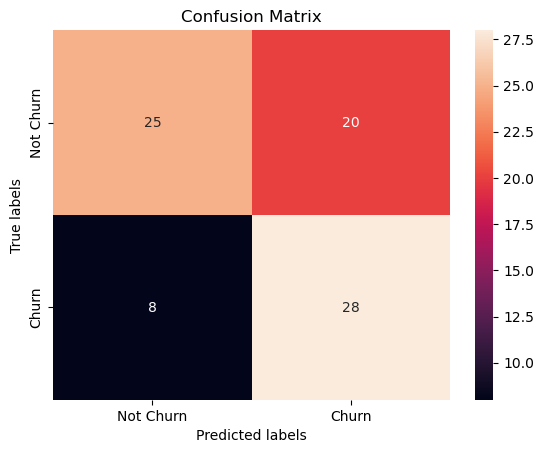

In [54]:
lr_predict=logreg_cv.predict(X_test)
lr_probab_predict= logreg_cv.predict_proba
plot_confusion_matrix(Y_test,lr_predict)

In [62]:
print('Accuracy: ',logreg_cv.score(X_test,Y_test))
print('Report:\n',classification_report(Y_test, yhat))

Accuracy:  0.654320987654321
Report:
               precision    recall  f1-score   support

           0       0.76      0.56      0.64        45
           1       0.58      0.78      0.67        36

    accuracy                           0.65        81
   macro avg       0.67      0.67      0.65        81
weighted avg       0.68      0.65      0.65        81



Random Forest

In [64]:
parameters_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2','None']
}


RF = RandomForestClassifier()

In [65]:
%%time
# define the grid search object
grid_search_rf = GridSearchCV(
    estimator = RF,
    param_grid = parameters_rf,
    scoring = 'accuracy',
    cv = 5
)
# execute search
rf_cv = grid_search_rf.fit(X_train, Y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-pac

CPU times: total: 5min 44s
Wall time: 5min 55s


In [66]:
print("tuned hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
accuracy : 0.7789423076923077


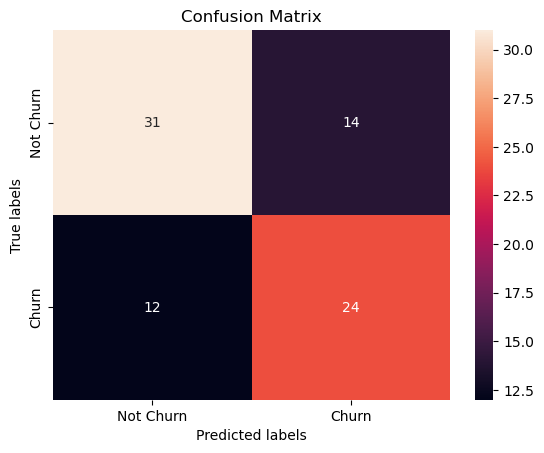

In [67]:
rf_predict=rf_cv.predict(X_test)
rf_probab_predict= rf_cv.predict_proba
plot_confusion_matrix(Y_test,rf_predict)

In [68]:
print('Accuracy: ',rf_cv.score(X_test,Y_test))
print('Report:\n',classification_report(Y_test, rf_predict))

Accuracy:  0.6790123456790124
Report:
               precision    recall  f1-score   support

           0       0.72      0.69      0.70        45
           1       0.63      0.67      0.65        36

    accuracy                           0.68        81
   macro avg       0.68      0.68      0.68        81
weighted avg       0.68      0.68      0.68        81



Logistic Regression and Random Forest perform similarly here but given avoiding Type 2 error is more important I have choosen Logistic Regeression, since it has better recall for Class 1.

**Fine-Tuning Model**

In [131]:
parameters_lr={
    'C': [0.001, 0.01, 0.1, 1, 10, 100,1000],
    'penalty': ['l2','elasticnet','l1'], 
    'solver': ['lbfgs', 'saga','newton-cg','liblinear']
}

In [135]:
%%time
lr=LogisticRegression()
grid_search_lr = GridSearchCV(
    estimator = lr,
    param_grid = parameters_lr,
    scoring = 'accuracy',
    cv = 10
)
logreg_cv=grid_search_lr.fit(X_train,Y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

CPU times: total: 6.3 s
Wall time: 6.33 s


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
420 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_

In [136]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.6795454545454545


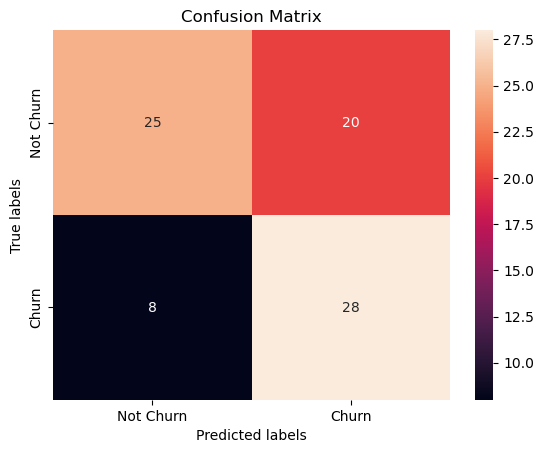

In [140]:
lr_predict=logreg_cv.predict(X_test)
lr_probab_predict= logreg_cv.predict_proba(X_test)
plot_confusion_matrix(Y_test,lr_predict)

In [141]:
print('Accuracy: ',logreg_cv.score(X_test,Y_test))
print('Report:\n',classification_report(Y_test, yhat))

Accuracy:  0.654320987654321
Report:
               precision    recall  f1-score   support

           0       0.76      0.56      0.64        45
           1       0.58      0.78      0.67        36

    accuracy                           0.65        81
   macro avg       0.67      0.67      0.65        81
weighted avg       0.68      0.65      0.65        81



Probablity of Reccurence

In [142]:
lr_probab_predict

array([[0.57587443, 0.42412557],
       [0.14773308, 0.85226692],
       [0.77030492, 0.22969508],
       [0.38028743, 0.61971257],
       [0.45549986, 0.54450014],
       [0.60511472, 0.39488528],
       [0.38177343, 0.61822657],
       [0.27919768, 0.72080232],
       [0.23180272, 0.76819728],
       [0.53661549, 0.46338451],
       [0.81625202, 0.18374798],
       [0.47943193, 0.52056807],
       [0.2414226 , 0.7585774 ],
       [0.51265385, 0.48734615],
       [0.73790132, 0.26209868],
       [0.44847522, 0.55152478],
       [0.04481447, 0.95518553],
       [0.84433592, 0.15566408],
       [0.49797826, 0.50202174],
       [0.40656958, 0.59343042],
       [0.88033801, 0.11966199],
       [0.26109726, 0.73890274],
       [0.4453287 , 0.5546713 ],
       [0.53661549, 0.46338451],
       [0.7825331 , 0.2174669 ],
       [0.43735783, 0.56264217],
       [0.47165362, 0.52834638],
       [0.66256155, 0.33743845],
       [0.30242471, 0.69757529],
       [0.68881933, 0.31118067],
       [0.